# USAD

## Environment

In [1]:
#!rm -r sample_data

In [2]:
#!git clone https://github.com/manigalati/usad

In [3]:
#%cd usad

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [5]:
!nvidia-smi -L

device = get_default_device()

GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU (UUID: GPU-dcd269f8-057f-2e80-ec3c-9d9be993ab1f)


## EDA - Data Pre-Processing

### Download dataset

In [6]:
##!mkdir input
#normal period
##!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
##!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

### Normal period

In [7]:
#Read data
normal = pd.read_csv("input/normal0.csv")#, nrows=1000)
normal = normal.drop(["window_start" , "window_end","Normal/Attack" ] , axis = 1)
normal.shape

(5040, 10)

In [8]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [10]:
normal.head(2)

0        1         2         3         4    5         6         7  \
0  0.000000  0.08385  0.004324  0.575483  0.186799  0.0  0.004038  0.641866   
1  0.002959  0.07913  0.007207  0.564531  0.189357  0.0  0.003546  0.608817   

          8         9  
0  0.617048  0.000000  
1  0.582943  0.002969

### Attack

In [11]:
#Read data
attack = pd.read_csv("input/attack0.csv")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["window_start" , "window_end", "Normal/Attack"] , axis = 1)
attack.shape

(990, 10)

In [12]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [13]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [14]:
attack.head(2)

0         1         2         3         4         5         6  \
0  0.010469  0.013552  0.021632  0.461056  0.318448  0.022628  0.459993   
1  0.008061  0.011041  0.018284  0.510743  0.325811  0.056856  0.877573   

          7        8         9  
0  0.035223  0.03216  0.261669  
1  0.051517  0.05212  0.282530

### Windows

In [15]:
window_size=12

In [16]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(5028, 12, 10)

In [17]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(978, 12, 10)

## Training

In [18]:
import torch.utils.data as data_utils

BATCH_SIZE =  100
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [19]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0286, val_loss2: 0.0267
Epoch [1], val_loss1: 0.0289, val_loss2: -0.0001
Epoch [2], val_loss1: 0.0292, val_loss2: -0.0099
Epoch [3], val_loss1: 0.0274, val_loss2: -0.0138
Epoch [4], val_loss1: 0.0269, val_loss2: -0.0159
Epoch [5], val_loss1: 0.0293, val_loss2: -0.0194
Epoch [6], val_loss1: 0.0301, val_loss2: -0.0213
Epoch [7], val_loss1: 0.0311, val_loss2: -0.0232
Epoch [8], val_loss1: 0.0317, val_loss2: -0.0246
Epoch [9], val_loss1: 0.0314, val_loss2: -0.0250
Epoch [10], val_loss1: 0.0328, val_loss2: -0.0268
Epoch [11], val_loss1: 0.0308, val_loss2: -0.0255
Epoch [12], val_loss1: 0.0307, val_loss2: -0.0258
Epoch [13], val_loss1: 0.0333, val_loss2: -0.0286
Epoch [14], val_loss1: 0.0293, val_loss2: -0.0252
Epoch [15], val_loss1: 0.0324, val_loss2: -0.0283
Epoch [16], val_loss1: 0.0303, val_loss2: -0.0265
Epoch [17], val_loss1: 0.0305, val_loss2: -0.0270
Epoch [18], val_loss1: 0.0328, val_loss2: -0.0293
Epoch [19], val_loss1: 0.0299, val_loss2: -0.0267
Epoch [20],

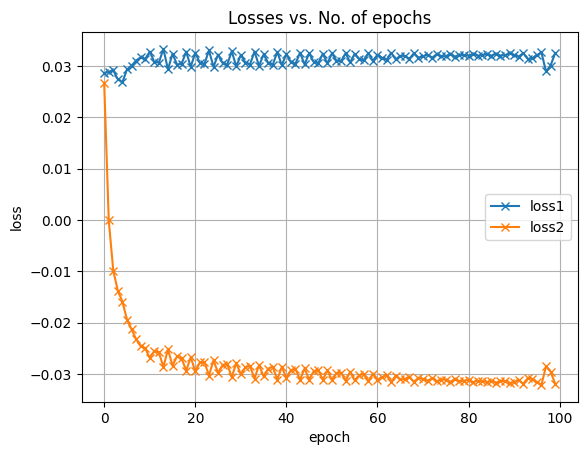

In [20]:
plot_history(history)

In [21]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [22]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [23]:
results=testing(model,test_loader)

In [24]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [25]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [26]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

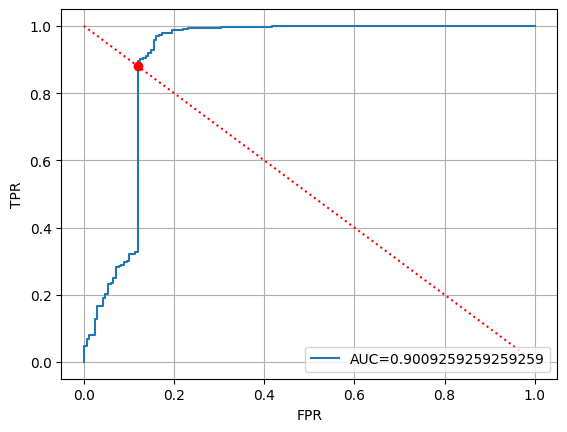

In [27]:
#print(f"NaN values in y_pred: {np.isnan(y_pred).sum()}")
y_pred = np.nan_to_num(y_pred, nan=np.nanmean(y_pred))  # 用均值替换NaN

threshold=ROC(y_test,y_pred)